In [38]:
%load_ext autoreload
%autoreload 2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob

import sys
sys.path.append('../python')
from functions import *
from models import *

import tensorflow as tf
from livelossplot import PlotLossesKeras
os.environ["CUDA_VISIBLE_DEVICES"] = "2" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# One patch

### Load a file and label the stream stars

In [3]:
df = load_file()

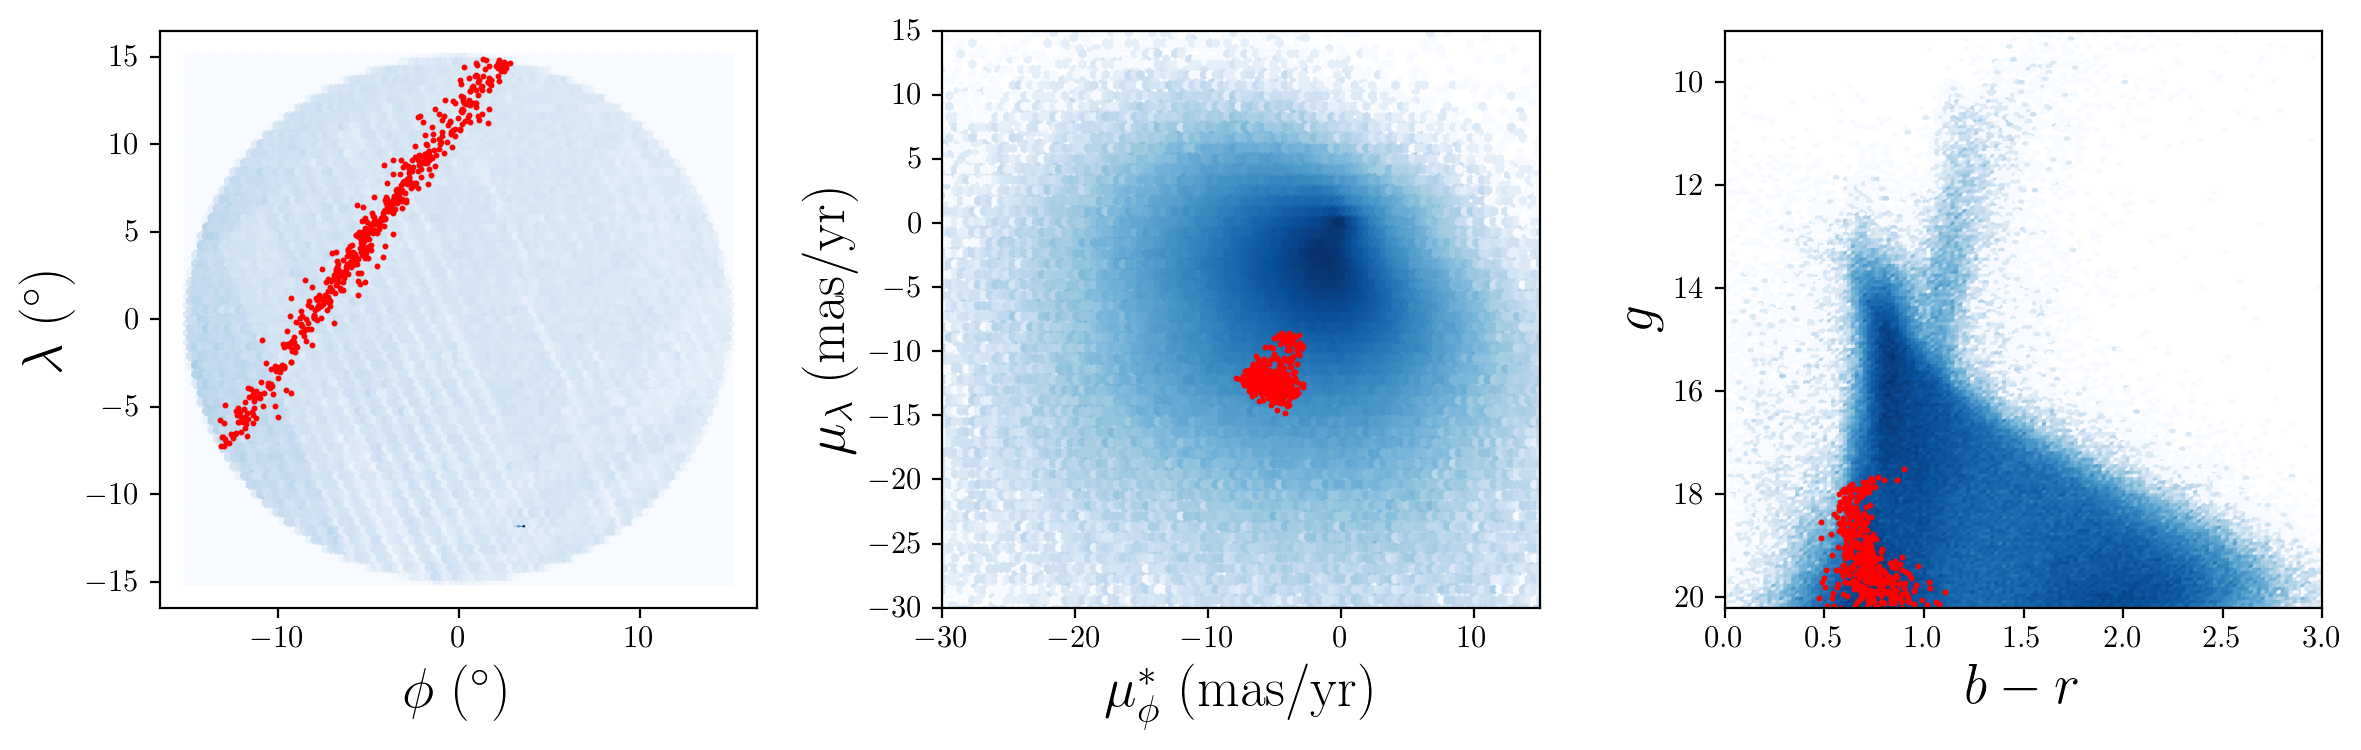

In [4]:
make_plots(df)

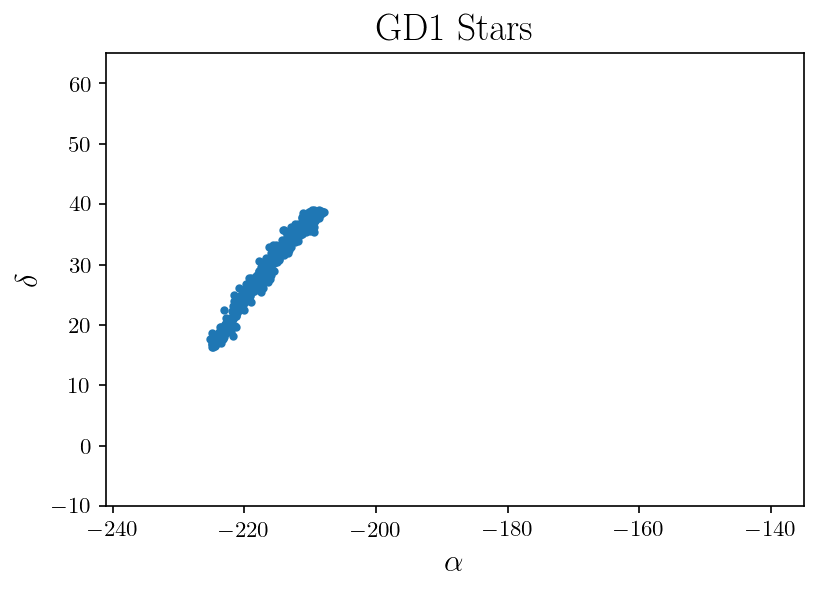

In [8]:
plt.figure(dpi=150)
plt.scatter(df[df.stream]['α_wrapped']-360, df[df.stream]['δ'], marker='.')
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\delta$")
plt.title("GD1 Stars");
plt.xlim(-241,-135);
plt.ylim(-10,65);

# Make dataframe of all patches

In [10]:
df = load_file('../gaia_data/gd1/gaiascan_l99.0_b50.2_ra224.7_dec60.6.npy')

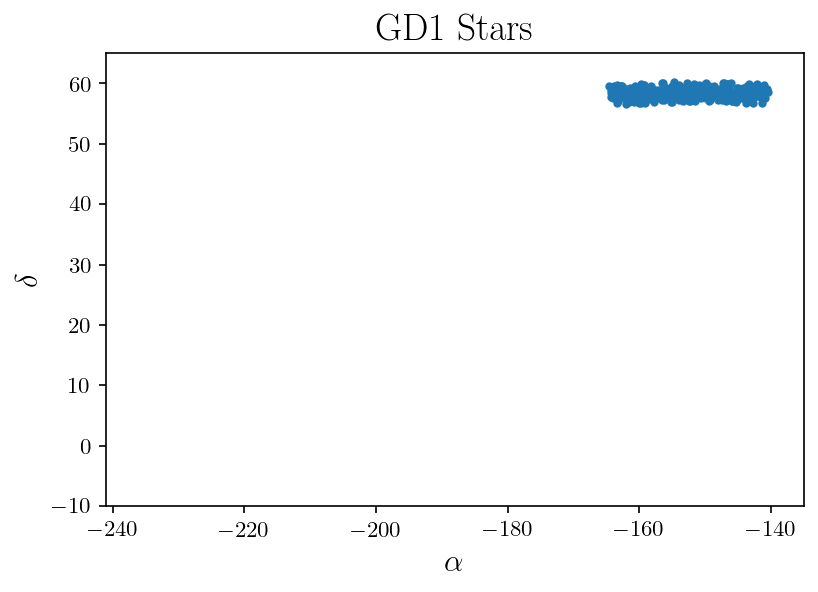

In [11]:
plt.figure(dpi=150)
plt.scatter(df[df.stream]['α_wrapped']-360, df[df.stream]['δ'], marker='.')
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\delta$")
plt.title("GD1 Stars");
plt.xlim(-241,-135);
plt.ylim(-10,65);

In [9]:
patch_list = [
 # b = 33.7 
 '../gaia_data/gd1/gaiascan_l195.0_b33.7_ra128.4_dec28.8.npy',
 '../gaia_data/gd1/gaiascan_l210.0_b33.7_ra132.6_dec16.9.npy',
 '../gaia_data/gd1/gaiascan_l225.0_b33.7_ra138.1_dec5.7.npy', 
 # b = 41.8 
 '../gaia_data/gd1/gaiascan_l187.5_b41.8_ra136.5_dec36.1.npy',
 '../gaia_data/gd1/gaiascan_l202.5_b41.8_ra138.8_dec25.1.npy',
 '../gaia_data/gd1/gaiascan_l217.5_b41.8_ra142.7_dec14.5.npy', 
 # b = 50.2 
 '../gaia_data/gd1/gaiascan_l99.0_b50.2_ra224.7_dec60.6.npy',
 '../gaia_data/gd1/gaiascan_l117.0_b50.2_ra202.4_dec66.5.npy',
 '../gaia_data/gd1/gaiascan_l135.0_b50.2_ra174.3_dec65.1.npy',
 '../gaia_data/gd1/gaiascan_l153.0_b50.2_ra156.2_dec57.5.npy',
 '../gaia_data/gd1/gaiascan_l171.0_b50.2_ra148.6_dec47.0.npy',
 '../gaia_data/gd1/gaiascan_l189.0_b50.2_ra146.9_dec35.6.npy',
 '../gaia_data/gd1/gaiascan_l207.0_b50.2_ra148.6_dec24.2.npy',
 # b = 58.4 
 '../gaia_data/gd1/gaiascan_l101.2_b58.4_ra212.7_dec55.2.npy',
 '../gaia_data/gd1/gaiascan_l123.8_b58.4_ra192.0_dec58.7.npy',
 '../gaia_data/gd1/gaiascan_l146.2_b58.4_ra171.8_dec54.7.npy',
 '../gaia_data/gd1/gaiascan_l168.8_b58.4_ra160.5_dec45.5.npy',
 '../gaia_data/gd1/gaiascan_l191.2_b58.4_ra156.9_dec34.1.npy',
 # b = 66.4 
 '../gaia_data/gd1/gaiascan_l105.0_b66.4_ra203.7_dec49.1.npy',
 '../gaia_data/gd1/gaiascan_l135.0_b66.4_ra185.4_dec50.0.npy',
 '../gaia_data/gd1/gaiascan_l165.0_b66.4_ra171.4_dec43.0.npy',    
]

In [14]:
# for file in tqdm(patch_list):
#     df = load_file(file)
#     df["patch_id"] = patch_list.index(file)
#     df.to_hdf(file[:-4]+".h5", "df")

In [ ]:
dfs = []
for file in tqdm(patch_list):
    df = pd.read_hdf(file[:-4]+".h5")
    dfs.append(df)
df_all = pd.concat(dfs)

In [ ]:
plt.figure(dpi=150)
plt.scatter(df_all[df_all.stream]['α'], df_all[df_all.stream]['δ'], marker='.')
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\delta$")
plt.title("GD1 Stars in All Patches");
# plt.xlim(-11,11);
# plt.ylim(-11,11);

In [ ]:
for patch_id in df_all.patch_id.unique(): 
    df = df_all[df_all.patch_id == patch_id]
    
    fig = plt.figure(figsize=(12,4), dpi=200, tight_layout=True)
    ax = fig.add_subplot(131)
    ax.hist2d(df['ϕ'], df['λ'], bins=100, cmap="Blues");
    ax.scatter(df[df.stream]['ϕ'], df[df.stream]['λ'], marker='.', s=5, color='red')
    ax.set_xlabel(r'$\phi~(^\circ)$',fontsize=20)
    ax.set_ylabel(r'$\lambda~(^\circ)$',fontsize=20)
    ax.set_xlim(-11,11);
    ax.set_ylim(-11,11);

    ax = fig.add_subplot(132)
    ax.hexbin(df['μ_ϕcosλ'], df['μ_λ'], cmap='Blues', bins='log', gridsize=400, mincnt=1)
    ax.scatter(df[df.stream]['μ_ϕcosλ'], df[df.stream]['μ_λ'], marker='.', s=5, color='red')
    ax.set_xlim(-30,15)
    ax.set_ylim(-30,15)
    ax.set_xlabel(r'$\mu_\phi^*$ (mas/yr)',fontsize=20)
    ax.set_ylabel(r'$\mu_\lambda$ (mas/yr)',fontsize=20)

    ax = fig.add_subplot(133)
    ax.hexbin(df['b-r'], df['g'], cmap='Blues', bins='log', gridsize=400, mincnt=1)
    ax.scatter(df[df.stream]['b-r'], df[df.stream]['g'], marker='.', s=5, color='red')
    ax.set_xlabel(r'$b-r$',fontsize=20)
    ax.set_ylabel(r'$g$',fontsize=20)
    ax.set_xlim(0,3)
    ax.set_ylim(9,20.2)
    ax.invert_yaxis() 

In [ ]:
# df_all = pd.concat([df for df in dfs])
# df_all['α'] = df_all['α'].apply(lambda x: x if x > 100 else x + 360) # wrap around plot

In [ ]:
plt.figure(dpi=150)
plt.scatter(df_all[df_all.stream].α, df_all[df_all.stream].δ, marker='.')
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\delta$")
plt.title("GD1 Stars in All Patches");

That's a little funky, let's modify it:

In [ ]:
gd1_stars_in_patches['α_new'] = gd1_stars_in_patches['α'].apply(lambda x: x if x > 100 else x + 360)

In [ ]:
plt.figure(figsize=(12,3),dpi=150)
plt.scatter(gd1_stars_in_patches.α_new, gd1_stars_in_patches.δ, marker='.', c=gd1_stars_in_patches.μ_δ)
plt.colorbar(label=r"$\mu_\delta$")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\delta$")
plt.title("GD1 Stream (21 patches)");

In [ ]:
# df_all.to_hdf("gd1_allpatches.h5", key="df")

# Run on each of the 21 GD1 patches

In [ ]:
df_all = pd.read_hdf("../gaia_data/gd1/gd1_allpatches.h5")
df_all['ϕ'] = df_all.lat
df_all['λ'] = df_all.lon
df_all['μ_ϕcosλ'] = df_all.μ_loncoslat # these are flipped
df_all['μ_λ'] = df_all.μ_lat # these are flipped
df_all.to_hdf("../gaia_data/gd1/gd1_allpatches.h5", "df")

In [ ]:
df_all.keys()

In [ ]:
df_all = pd.read_hdf("../gaia_data/gd1/gd1_allpatches.h5")
plot_coords(df_all, save_folder="test")

In [ ]:
patch_list = [
 # b = 3λ./gaia_data/gd1/gaiascan_l195.0_b33.7_ra128.4_dec28.8.npy',
 './gaia_data/gd1/gaiascan_l210.0_b33.7_ra132.6_dec16.9.npy',
 './gaia_data/gd1/gaiascan_l225.0_b33.7_ra138.1_dec5.7.npy', 
 # b = 41.8 
 './gaia_data/gd1/gaiascan_l187.5_b41.8_ra136.5_dec36.1.npy',
 './gaia_data/gd1/gaiascan_l202.5_b41.8_ra138.8_dec25.1.npy',
 './gaia_data/gd1/gaiascan_l217.5_b41.8_ra142.7_dec14.5.npy', 
 # b = 50.2 
 './gaia_data/gd1/gaiascan_l99.0_b50.2_ra224.7_dec60.6.npy',
 './gaia_data/gd1/gaiascan_l117.0_b50.2_ra202.4_dec66.5.npy',
 './gaia_data/gd1/gaiascan_l135.0_b50.2_ra174.3_dec65.1.npy',
 './gaia_data/gd1/gaiascan_l153.0_b50.2_ra156.2_dec57.5.npy',
 './gaia_data/gd1/gaiascan_l171.0_b50.2_ra148.6_dec47.0.npy',
 './gaia_data/gd1/gaiascan_l189.0_b50.2_ra146.9_dec35.6.npy',
 './gaia_data/gd1/gaiascan_l207.0_b50.2_ra148.6_dec24.2.npy',
 # b = 58.4 
 './gaia_data/gd1/gaiascan_l101.2_b58.4_ra212.7_dec55.2.npy',
 './gaia_data/gd1/gaiascan_l123.8_b58.4_ra192.0_dec58.7.npy',
 './gaia_data/gd1/gaiascan_l146.2_b58.4_ra171.8_dec54.7.npy',
 './gaia_data/gd1/gaiascan_l168.8_b58.4_ra160.5_dec45.5.npy',
 './gaia_data/gd1/gaiascan_l191.2_b58.4_ra156.9_dec34.1.npy',
 # b = 66.4 
 './gaia_data/gd1/gaiascan_l105.0_b66.4_ra203.7_dec49.1.npy',
 './gaia_data/gd1/gaiascan_l135.0_b66.4_ra185.4_dec50.0.npy',
 './gaia_data/gd1/gaiascan_l165.0_b66.4_ra171.4_dec43.0.npy',    
]

In [ ]:
### α0 and δ0 offsets of each patch 

offsets = {
    "patch_0" : (128.4, 28.8),
    "patch_1" : (132.6, 16.9),
    "patch_2" : (138.1, 5.7),
    "patch_3" : (136.5, 36.1),
    "patch_4" : (138.8, 25.1),
    "patch_5" : (142.7, 14.5),
    "patch_6" : (224.7, 60.6),
    "patch_7" : (202.4, 66.5),
    "patch_8" : (174.3, 65.1),
    "patch_9" : (156.2, 57.5),
    "patch_10" : (148.6, 47.0),
    "patch_11" : (146.9, 35.6),
    "patch_12" : (148.6, 24.2),
    "patch_13" : (212.7, 55.2),
    "patch_14" : (192.0, 58.7),
    "patch_15" : (171.8, 54.7),
    "patch_16" : (160.5, 45.5),
    "patch_17" : (156.9, 34.1),
    "patch_18" : (203.7, 49.1),
    "patch_19" : (185.4, 50.0),
    "patch_20" : (171.4, 43.0),
          }

In [ ]:
patches = []
for patch_id in range(21): 
    patch = df_all[df_all.patch_id == patch_id]
    patch['lon_absolute'] = patch.lon + offsets['patch_'+str(patch_id)][0]
    patch['lat_absolute'] = patch.lat + offsets['patch_'+str(patch_id)][1]
    patches.append(patch)
df = pd.concat(patches)

In [ ]:
plt.figure(dpi=200, figsize=(5,3.5))
plt.hist2d(df.lon_absolute, df.lat_absolute, bins=200);
plt.scatter(df[df.stream].lon_absolute, df[df.stream].lat_absolute, color="magenta", marker='.', s=1)
plt.xlabel(r'$\phi$');
plt.ylabel(r'$\lambda$');

In [ ]:
plt.figure(dpi=200, figsize=(5,3.5))
plt.hist2d(df.α, df.δ, bins=200);
plt.scatter(df[df.stream].α, df[df.stream].δ, color="magenta", marker='.', s=1)
plt.xlabel(r'$\alpha$');
plt.ylabel(r'$\delta$');

In [ ]:
df_all = df_all_noduplicates

In [ ]:
alphas = np.linspace(df_all[df_all.stream].α.min(), df_all[df_all.stream].α.max(), 20)
deltas = np.array([df_all[(df_all.stream & (np.abs(df_all.α - alpha) < 5))].δ.mean() for alpha in alphas])
limits = pd.DataFrame(zip(np.arange(len(alphas)),alphas,deltas), 
                      columns=["patch_id","α_center", "δ_center"])

def train_on_patch(patch_id):
    α_min = limits.iloc[patch_id]["α_center"]-10
    α_max = limits.iloc[patch_id]["α_center"]+10
    δ_min = limits.iloc[patch_id]["δ_center"]-10
    δ_max = limits.iloc[patch_id]["δ_center"]+10
    df = (df_all[(α_min < df_all.α) & (df_all.α < α_max) & 
                 (δ_min < df_all.δ) & (df_all.δ < δ_max)])
    return(df)

In [ ]:
plt.scatter(train_on_patch(0).α, train_on_patch(0).δ, alpha=0.01);
plt.scatter(train_on_patch(1).α, train_on_patch(1).δ, alpha=0.01);
plt.scatter(train_on_patch(2).α, train_on_patch(2).δ, alpha=0.01);
plt.scatter(alphas, deltas)

In [ ]:
df_all_noduplicates = df_all.drop_duplicates(subset=['α','δ','μ_α','μ_δ','color','mag'])

In [ ]:
len(df_all_noduplicates)

In [ ]:
df_all_noduplicates = pd.read_hdf("../gaia_data/gd1/gd1_allpatches_noduplicates.h5")
print(df_all_noduplicates.shape)

In [ ]:
plot_coords(df_all_noduplicates)

In [ ]:
# fig, axs = plt.subplots(figsize=(16,5), nrows=3, ncols=10,);
# plt.subplots_adjust(hspace=0.5)
# fig.suptitle("Via Machinae Patches", fontsize=18, y=1.05);

# for patch, ax in zip(df_all.patch_id.unique(), axs.ravel()):
#     # filter df for ticker and plot on specified axes
#     ax.hist2d(df_all[df_all.patch_id == patch].α, df_all[df_all.patch_id == patch].δ, bins=30)

#     # chart formatting
#     ax.set_title(patch)
# #     ax.get_legend().remove()
#     ax.set_xlabel("")

In [ ]:
target_stream = []
top_100_stars = []

n_patches = 10
alphas = np.linspace(df_all[df_all.stream].α.min(), df_all[df_all.stream].α.max(), n_patches)
deltas = np.array([df_all[(df_all.stream & (np.abs(df_all.α - alpha) < 5))].δ.mean() for alpha in alphas])
limits = pd.DataFrame(zip(np.arange(len(alphas)),alphas,deltas), columns=["patch_id","α_center", "δ_center"])

for patch_id in tqdm(limits.patch_id.unique()):
    α_min = limits.iloc[patch_id]["α_center"]-10
    α_max = limits.iloc[patch_id]["α_center"]+10
    δ_min = limits.iloc[patch_id]["δ_center"]-10
    δ_max = limits.iloc[patch_id]["δ_center"]+10
    df = (df_all[(α_min < df_all.α) & (df_all.α < α_max) & 
                 (δ_min < df_all.δ) & (df_all.δ < δ_max)])
    if np.sum(df.stream)/len(df) < 0.0001: # skip patches with hardly any stream stars
        continue
    else:
#         try: 
#             plt.figure()
#             plt.scatter(df[df.stream].α, df[df.stream].δ, alpha=0.1)
#             visualize_stream(df)
#         except: 
#             continue
        target_stream.append(df[df.stream])                
        df_train = signal_sideband(df, save_folder="test/patches/patch{}".format(str(patch_id)),
                        sb_min = df[df.stream].μ_δ.min(),
                        sr_min = df[df.stream].μ_δ.min()+1,
                        sr_max = df[df.stream].μ_δ.max()-1,
                        sb_max = df[df.stream].μ_δ.max()
                        )
        tf.keras.backend.clear_session()
        test = train(df_train, 
          n_folds = 1, 
          best_of_n_loops = 1,
          layer_size = 128, 
          batch_size = 10000, 
          dropout = 0.2, 
          epochs = 1000, 
          patience = 30,
          save_folder="test/patches/patch{}".format(str(patch_id)),)
        top_100_stars.append(test.sort_values('nn_score',ascending=False)[:100])

Try with multiprocessing:

In [ ]:
from multiprocessing import Pool

n_patches = 2
alphas = np.linspace(df_all[df_all.stream].α.min(), df_all[df_all.stream].α.max(), n_patches)
deltas = np.array([df_all[(df_all.stream & (np.abs(df_all.α - alpha) < 5))].δ.mean() for alpha in alphas])
limits = pd.DataFrame(zip(np.arange(len(alphas)),alphas,deltas), columns=["patch_id","α_center", "δ_center"])

def my_func(patch_id):
    α_min = limits.iloc[patch_id]["α_center"]-10
    α_max = limits.iloc[patch_id]["α_center"]+10
    δ_min = limits.iloc[patch_id]["δ_center"]-10
    δ_max = limits.iloc[patch_id]["δ_center"]+10
    df = (df_all[(α_min < df_all.α) & (df_all.α < α_max) & 
                 (δ_min < df_all.δ) & (df_all.δ < δ_max)])
    if np.sum(df.stream)/len(df) > 0.0001: # skip patches with hardly any stream stars
        df_train = signal_sideband(df, save_folder="test/patches/patch{}".format(str(patch_id)),
                        sb_min = df[df.stream].μ_δ.min(),
                        sr_min = df[df.stream].μ_δ.min()+1,
                        sr_max = df[df.stream].μ_δ.max()-1,
                        sb_max = df[df.stream].μ_δ.max(), 
                        verbose=False,
                        )
        tf.keras.backend.clear_session()
        test = train(df_train, 
          n_folds = 1, 
          best_of_n_loops = 1,
          layer_size = 128, 
          batch_size = 10000, 
          dropout = 0.2, 
          epochs = 2, 
          patience = 30,
          l2_reg = 0,
          save_folder="test/patches/patch{}".format(str(patch_id)),
          verbose=False,)
        top_100_stars = test.sort_values('nn_score',ascending=False)[:100]
        
    # return results for the record as pd.Series
    print("Finished Patch #{}".format(str(patch_id)))
    return test

pool = Pool(processes=2)
results = pool.map(my_func, limits.patch_id.unique())
pool.close()
pool.join()

In [ ]:
all_gd1_stars = []
cwola_stars = []

for test in results:
    n_top_stars = np.min([len(test[test.stream]),100])
    patch_top_stars = test.sort_values('nn_score',ascending=False)[:n_top_stars]
    all_gd1_stars.append(test[test.stream])
    cwola_stars.append(patch_top_stars)
    
all_gd1_stars = pd.concat([df for df in all_gd1_stars])
cwola_stars = pd.concat([df for df in cwola_stars])

plt.figure(dpi=200, figsize=(12,4))
plt.scatter(all_gd1_stars.α, all_gd1_stars.δ, marker='.', s=2, 
            color="lightgray", label="GD1")
plt.scatter(cwola_stars[cwola_stars.stream == False].α, cwola_stars[cwola_stars.stream == False].δ, marker='.', s=2, 
            color="darkorange", label="CWoLa (Non-Match)")
plt.scatter(cwola_stars[cwola_stars.stream].α, cwola_stars[cwola_stars.stream].δ, marker='.', s=2, 
            color="crimson", label="CWoLa (Match)")
plt.legend()
plt.xlabel(r"$\alpha$ [\textdegree]");
plt.xlim(120,220);

# Remake Via Machinae plot from test dataframes saved during the training

In [16]:
# fig = plt.figure(figsize=(5,5))
# plt.scatter(cwola_stars[cwola_stars.patch_id == 0].α, cwola_stars[cwola_stars.patch_id == 0].δ, marker='.')

In [60]:
files

['../trained_models/new_sr1_sb3/patches/patch0/df_test.h5',
 '../trained_models/new_sr1_sb3/patches/patch1/df_test.h5',
 '../trained_models/new_sr1_sb3/patches/patch11/df_test.h5',
 '../trained_models/new_sr1_sb3/patches/patch2/df_test.h5',
 '../trained_models/new_sr1_sb3/patches/patch3/df_test.h5',
 '../trained_models/new_sr1_sb3/patches/patch4/df_test.h5',
 '../trained_models/new_sr1_sb3/patches/patch5/df_test.h5']

33.333333333333336
31.60919540229885
69.66666666666667
81.33333333333333
77.3076923076923
0.0
skipping ../trained_models/new_sr1_sb3/patches/patch2/df_test.h5
77.65957446808511
75.66666666666667
45.80152671755725
Purity = 69% in top CWoLa-identified stars


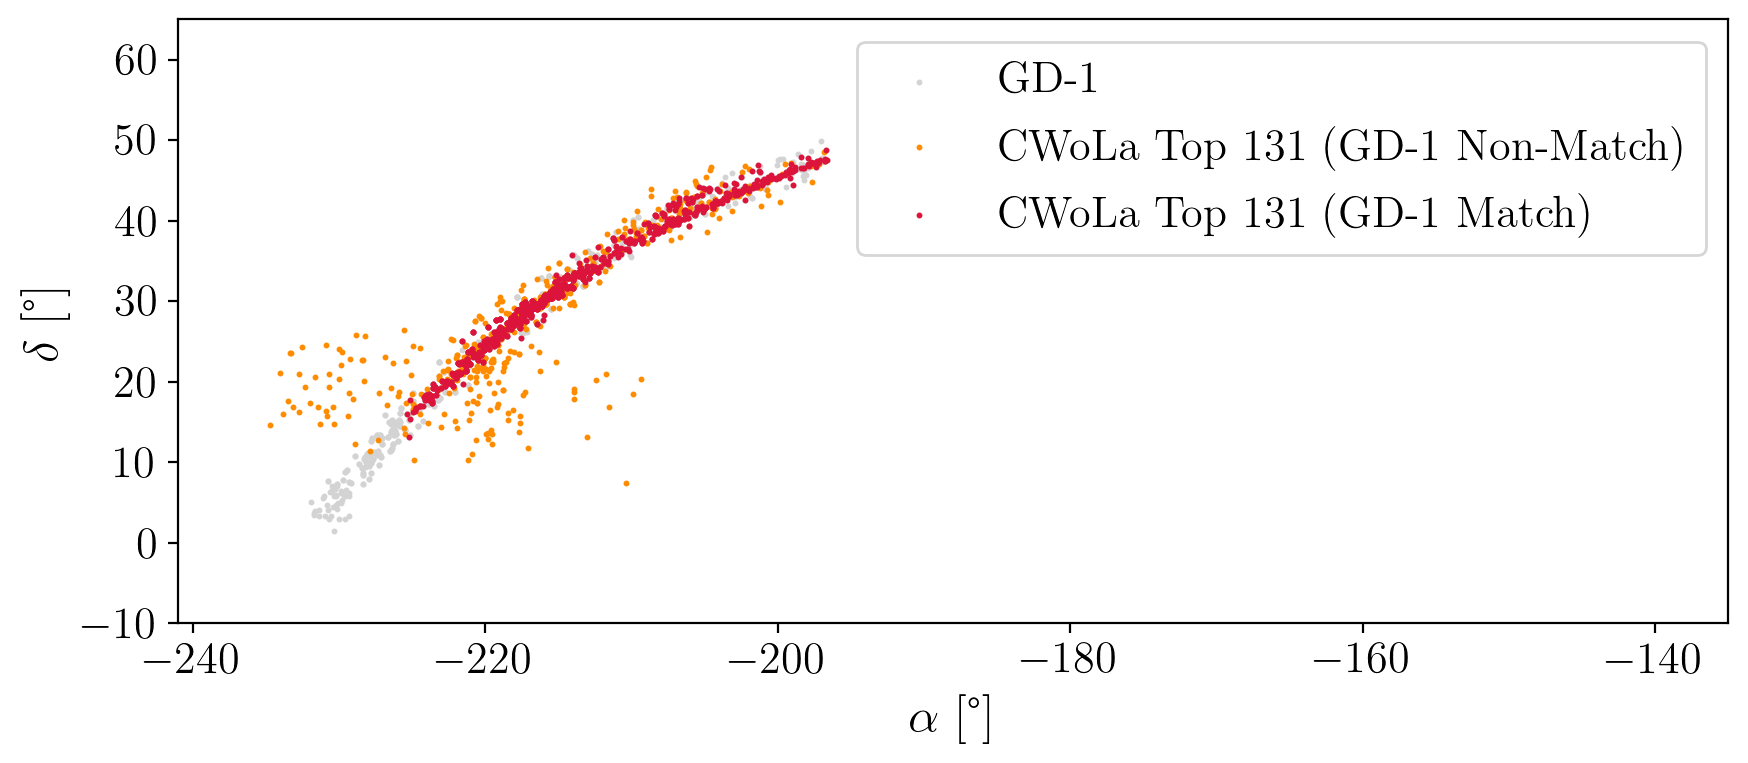

In [68]:
all_gd1_stars = []
cwola_stars = []

# files = sorted(glob("../trained_models/aps_50_patches_nfolds1/patches/patch*/df_test.h5"))
# files = sorted(glob("../trained_models/vm_sr1_sb3_50patches/patches/patch*/df_test.h5"))
files = sorted(glob("../trained_models/new_sr1_sb3/patches/patch*/df_test.h5"))

for file in files: # use all files to create stream stars
    test = pd.read_hdf(file)
    test = fiducial_cuts(test)
    all_gd1_stars.append(test[test.stream])    

for file in files:
    test = pd.read_hdf(file)
    test = fiducial_cuts(test)
    n_top_stars = np.min([len(test[test.stream]),300])
    patch_top_stars = test.sort_values('nn_score',ascending=False)[:n_top_stars]
    purity = 100*len(patch_top_stars[patch_top_stars.stream])/len(patch_top_stars)
    print(purity)
    if purity < 20:
        print("skipping "+str(file))
        continue
    else:
        cwola_stars.append(patch_top_stars)
    
all_gd1_stars = pd.concat([df for df in all_gd1_stars])
cwola_stars = pd.concat([df for df in cwola_stars])

all_gd1_stars.reset_index(inplace=True)
all_gd1_stars.drop_duplicates(subset = 'index')

cwola_stars.reset_index(inplace=True)
cwola_stars.drop_duplicates(subset = 'index')

all_gd1_stars['α'] = all_gd1_stars['α']-360
cwola_stars['α'] = cwola_stars['α']-360

markersize = 5
plt.figure(dpi=200, figsize=(10,4))
plt.scatter(all_gd1_stars.α_wrapped - 360, all_gd1_stars.δ, marker='.', s=markersize, 
            color="lightgray", label="GD-1")
plt.scatter(cwola_stars[cwola_stars.stream == False].α_wrapped - 360, cwola_stars[cwola_stars.stream == False].δ, marker='.', s=markersize, 
            color="darkorange", label="CWoLa Top {} (GD-1 Non-Match)".format(n_top_stars))
plt.scatter(cwola_stars[cwola_stars.stream].α_wrapped - 360, cwola_stars[cwola_stars.stream].δ, marker='.', s=markersize, 
            color="crimson", label="CWoLa Top {} (GD-1 Match)".format(n_top_stars))
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel(r"$\alpha$ [\textdegree]", fontsize=18);
plt.ylabel(r"$\delta$ [\textdegree]", fontsize=18);
# plt.xlim(120,220);
plt.xlim(-241,-135);
plt.ylim(-10,65);
# plt.savefig("via_machinae_aps_50patches_top50.pdf", bbox_inches="tight");

print("Purity = {:.0f}% in top CWoLa-identified stars".format(100*len(cwola_stars[cwola_stars.stream])/len(cwola_stars)))
# print("Purity = {:.0f}% vs. all of GD-1".format(100*len(cwola_stars[cwola_stars.stream])/len(all_gd1_stars)))

In [ ]:
R = np.array([[-0.4776303088, -0.1738432154, 0.8611897727], 
              [0.510844389, -0.8524449229, 0.111245042], 
              [0.7147776536, 0.4930681392, 0.4959603976]])

np.matmul(R, np.array([1,2,3]))

In [ ]:
def to_phi_coords(df):
    
    R = np.array([[-0.4776303088, -0.1738432154, 0.8611897727], 
                  [0.510844389, -0.8524449229, 0.111245042], 
                  [0.7147776536, 0.4930681392, 0.4959603976]])
    
    v_old = np.array([np.cos(df.α+360)*np.cos(df.δ), 
                      np.sin(df.α+360)*np.cos(df.δ),
                      np.sin(df.δ)])
    
    v_new = np.matmul(R, v_old) # (cosϕ1cosϕ2, sinϕ1cosϕ2, sinϕ2)
        
    df['ϕ_1'] = np.arctan(v_new[1]/v_newb[0])
    df['ϕ_2'] = np.arcsin(v_new[2])

    return df

In [ ]:
all_gd1_stars = to_phi_coords(all_gd1_stars)
cwola_stars = to_phi_coords(cwola_stars)

In [ ]:
markersize = 5
plt.figure(dpi=200, figsize=(10,4))
plt.scatter(all_gd1_stars['ϕ_1'], all_gd1_stars['ϕ_2'], marker='.', s=markersize, 
            color="lightgray", label="GD-1")
# plt.scatter(cwola_stars[cwola_stars.stream == False].α, cwola_stars[cwola_stars.stream == False].δ, marker='.', s=markersize, 
#             color="darkorange", label="CWoLa Top {} (GD-1 Non-Match)".format(n_top_stars))
# plt.scatter(cwola_stars[cwola_stars.stream].α, cwola_stars[cwola_stars.stream].δ, marker='.', s=markersize, 
#             color="crimson", label="CWoLa Top {} (GD-1 Match)".format(n_top_stars))
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel(r"$\phi_1$ [\textdegree]", fontsize=18);
plt.ylabel(r"$\phi_2$ [\textdegree]", fontsize=18);
# plt.xlim(-100,20);
# plt.ylim(-5,1);

In [ ]:
### OLD 
all_gd1_stars = []
cwola_stars = []

files = sorted(glob("../trained_models/aps_50_patches_nfolds1/patches/patch*/df_test.h5"))

for file in files[5:-8]:
    test = pd.read_hdf(file)
    n_top_stars = np.min([len(test[test.stream]),50])
    patch_top_stars = test.sort_values('nn_score',ascending=False)[:n_top_stars]
    all_gd1_stars.append(test[test.stream])
    cwola_stars.append(patch_top_stars)
    
all_gd1_stars = pd.concat([df for df in all_gd1_stars])
cwola_stars = pd.concat([df for df in cwola_stars])

plt.figure(dpi=200, figsize=(12,4))
plt.scatter(all_gd1_stars.α, all_gd1_stars.δ, marker='.', s=10, 
            color="lightgray", label="GD-1")
# plt.scatter(cwola_stars[cwola_stars.stream == False].α, cwola_stars[cwola_stars.stream == False].δ, marker='.', s=10, 
#             color="darkorange", label="CWoLa Top 50 (GD-1 Non-Match)")
plt.scatter(cwola_stars[cwola_stars.stream].α, cwola_stars[cwola_stars.stream].δ, marker='x', s=30, 
            color="crimson", label="CWoLa Top 50 (GD-1 Match)")
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel(r"$\alpha$ [\textdegree]", fontsize=18);
plt.ylabel(r"$\delta$ [\textdegree]", fontsize=18);
plt.xlim(120,220);
plt.savefig("via_machinae_aps_50patches_top50_onlymatches.pdf", bbox_inches="tight");

## Add promising stars

In [ ]:
labeled = cwola_stars[cwola_stars.stream]
unlabeled = cwola_stars[cwola_stars.stream == False]

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(12,4), dpi=300, tight_layout=True)

ax = axs[0]
ax.set_title("Stellar Positions")
ax.scatter(all_gd1_stars.α, all_gd1_stars.δ, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.α, labeled.δ, marker='.', color="crimson",label="Labeled GD1 (Top {})".format(n_top_stars))
ax.scatter(unlabeled.α, unlabeled.δ, marker='.', color="dodgerblue", label="Unlabeled (Top {})".format(n_top_stars))
# ax.set_xlim(-15,15)
# ax.set_ylim(-15,15)
ax.legend()
ax.set_xlabel(r"$\alpha$[\textdegree]")
ax.set_ylabel(r"$\delta$[\textdegree]");

ax = axs[1]
ax.set_title("Stellar Velocities")
ax.scatter(all_gd1_stars.μ_α, all_gd1_stars.μ_δ, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.μ_α, labeled.μ_δ, marker='.', color="crimson", label="CWoLa Top {} (Labeled)".format(n_top_stars))
ax.scatter(unlabeled.μ_α, unlabeled.μ_δ, marker='.', color="dodgerblue", label="CWoLa Top {} (Unlabeled)".format(n_top_stars))
# ax.set_xlim(-15,15)
# ax.set_ylim(-15,15)
ax.set_xlabel(r"$\mu_{\alpha}$")
ax.set_ylabel(r"$\mu_{\delta}$");

ax = axs[2]
ax.set_title("Magnitude vs. Color")
ax.scatter(all_gd1_stars.color, all_gd1_stars.mag, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.color, labeled.mag, marker='.', color="crimson", label="CWoLa Top {} (Labeled)".format(n_top_stars))
ax.scatter(unlabeled.color, unlabeled.mag, marker='.', color="dodgerblue", label="CWoLa Top {} (Unlabeled)".format(n_top_stars))
ax.set_xlabel(r"Color")
ax.set_ylabel(r"Magnitude");
# plt.savefig("../plots/mislabeled_triptych.png")

Identify promising unlabeled stars...

In [ ]:
from scipy.spatial import distance_matrix
cols = ["μ_α", "δ", "α", "color", "mag"]
dists = distance_matrix(labeled[cols].to_numpy(), unlabeled[cols].to_numpy())
closest_labeled = labeled.iloc[dists.argmin(axis=0)]
deltas = unlabeled[cols].to_numpy()-closest_labeled[cols].to_numpy()
distances = np.sqrt(np.sum(deltas**2, axis=1))
unlabeled['5d_distance'] = distances

plt.figure(dpi=300)
plt.hist(unlabeled["5d_distance"], bins=60)
plt.title("5D Distances: Unlabeled to Closest Labeled Star");
plt.ylabel("Counts")
plt.xlabel("5D Euclidean Distance");
# plt.savefig("../plots/5d_distance.png")

In [ ]:
# promising = unlabeled[(unlabeled['5d_distance'] < 1)] # restrict by a specific distance
promising = unlabeled[(unlabeled['5d_distance'] < unlabeled['5d_distance'].quantile(0.1))] # restrict to the top x%

In [ ]:
len(promising)

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(12,4), dpi=300, tight_layout=True)

ax = axs[0]
ax.set_title("Stellar Positions")
ax.scatter(all_gd1_stars.α, all_gd1_stars.δ, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.α, labeled.δ, marker='.', color="crimson",label="Labeled GD1 (Top {})".format(n_top_stars))
ax.scatter(promising.α, promising.δ, marker='.', color="dodgerblue", label="promising (Top {})".format(n_top_stars))
# ax.set_xlim(-15,15)
# ax.set_ylim(-15,15)
ax.legend()
ax.set_xlabel(r"$\alpha$[\textdegree]")
ax.set_ylabel(r"$\delta$[\textdegree]");

ax = axs[1]
ax.set_title("Stellar Velocities")
ax.scatter(all_gd1_stars.μ_α, all_gd1_stars.μ_δ, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.μ_α, labeled.μ_δ, marker='.', color="crimson", label="CWoLa Top {} (Labeled)".format(n_top_stars))
ax.scatter(promising.μ_α, promising.μ_δ, marker='.', color="dodgerblue", label="CWoLa Top {} (promising)".format(n_top_stars))
# ax.set_xlim(-15,15)
# ax.set_ylim(-15,15)
ax.set_xlabel(r"$\mu_{\alpha}$")
ax.set_ylabel(r"$\mu_{\delta}$");

ax = axs[2]
ax.set_title("Magnitude vs. Color")
ax.scatter(all_gd1_stars.color, all_gd1_stars.mag, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.color, labeled.mag, marker='.', color="crimson", label="CWoLa Top {} (Labeled)".format(n_top_stars))
ax.scatter(promising.color, promising.mag, marker='.', color="dodgerblue", label="CWoLa Top {} (promising)".format(n_top_stars))
ax.set_xlabel(r"Color")
ax.set_ylabel(r"Magnitude");
# plt.savefig("../plots/mislabeled_triptych.png")

In [ ]:
plt.figure(dpi=200, figsize=(12,4))
plt.scatter(all_gd1_stars.α, all_gd1_stars.δ, marker='.', s=10, 
            color="lightgray", label="GD1")
plt.scatter(promising.α, promising.δ, marker='.', s=10, 
            color="dodgerblue", label="CWoLa (Promising Candidates)")
plt.scatter(cwola_stars[cwola_stars.stream].α, cwola_stars[cwola_stars.stream].δ, marker='.', s=10, 
            color="crimson", label="CWoLa (Match)")
plt.legend(fontsize=13)
plt.xlabel(r"$\alpha$ [\textdegree]");
plt.ylabel(r"$\delta$ [\textdegree]");
plt.xlim(120,220);
# plt.savefig("via_machinae_aps_50patches_top50.png");

## scratch

In [ ]:
import pandas as pd
from random import randrange
from multiprocessing import Pool

#Trivial example function 
def my_func(record):
    sub_df = df.loc[df['Record'] == record]
    sub_df['Result'] = randrange(0,100)
    # return results for the record as pd.Series
    return sub_df['Result']  

In [ ]:
d = {'Record': ['A', 'A', 'B', 'B'], 'Values': [100, 200, 50, 70]}
df = pd.DataFrame(d)
all_records = df['Record'].unique()

In [ ]:
pool = Pool(processes=2)
results = pool.map(my_func, all_records)
pool.close()
pool.join()

# concatenate results into a single pd.Series
results = pd.concat(results)

# join results with original df
joined_df = df.join(results)

print(joined_df)

In [ ]:
id = 20
α_min = df_all[df_all.patch_id == id].α.min()
α_max = df_all[df_all.patch_id == id].α.max()
δ_min = df_all[df_all.patch_id == id].δ.min()
δ_max = df_all[df_all.patch_id == id].δ.max()

visualize_stream(df_all[(α_min < df_all.α) & (df_all.α < α_max) & 
                        (δ_min < df_all.δ) & (df_all.δ < δ_max)])

Hand-pick limits for each patch:

In [ ]:
limits = pd.DataFrame([
                  [0, -15, -13.5, -11, -10],
                  [1, -14, -13, -12, -11],
                  [2, -14, -13, -11.5, -10],
                  [3, -14, -13, -11, -10],
                  [4, -15, -14, -12, -11],
                  [5, -15, -14, -12, -11],
                  [6, -5, -4, -2.5, 2],
                  [7, -10, -9.5, -8, -7],
                  [8, -9, -8, -7, -6],
                  [9, -9, -8, -7, -6],
                  [10, -12.5, -12, -11, -10],
                  [11, -14, -13, -11, -10],
                  [12, -14, -13, -12, -11],
                  [13, -6, -5, -4, -2],
                  [14, -9, -8, -7, -6],
                  [15, -9, -8, -7, -6],
                  [16, -14, -13, -11, -10],
                  [17, -14, -13, -12, -11],
                  [18, -6, -5, -3, -2],
                  [19, -9, -8, -6, -5],
                  [20, -9, -8.5, -6, -5.5],
                  ],
                  columns=["patch_id","sb_min","sr_min","sr_max","sb_max"])

Run over each patch:

In [ ]:
target_stream = []
top_100_stars = []

## Scan over patches
for patch_id in tqdm(limits.patch_id.unique()):
    α_min = df_all[df_all.patch_id == patch_id].α.min()
    α_max = df_all[df_all.patch_id == patch_id].α.max()
    δ_min = df_all[df_all.patch_id == patch_id].δ.min()
    δ_max = df_all[df_all.patch_id == patch_id].δ.max()

    df = df_all[(α_min < df_all.α) & (df_all.α < α_max) & 
                (δ_min < df_all.δ) & (df_all.δ < δ_max)]
    
    if np.sum(df.stream)/len(df) < 0.0001: # skip patches with hardly any stream stars
        continue
    else:
        try: 
            plt.scatter(df[df.stream].α, df[df.stream].δ, alpha=0.1)
#             visualize_stream(df)
        except: 
            continue
#         target_stream.append(df[df.stream])  
#         df_train = signal_sideband(df,
#                         sb_min = float(limits[limits.patch_id == patch_id].sb_min),
#                         sr_min = float(limits[limits.patch_id == patch_id].sr_min),
#                         sr_max = float(limits[limits.patch_id == patch_id].sr_max),
#                         sb_max = float(limits[limits.patch_id == patch_id].sb_max),
#                         )

#         tf.keras.backend.clear_session()
#         test = train(df_train, 
#           n_folds = 1, 
#           best_of_n_loops = 1,
#           layer_size = 128, 
#           batch_size = 1000, 
#           dropout = 0.2, 
#           epochs = 1000, 
#           patience = 30)
#         top_100_stars.append(test.sort_values('nn_score',ascending=False)[:100])

In [ ]:
all_gd1_stars = pd.concat([df for df in target_stream])
cwola_stars = pd.concat([df for df in top_100_stars])

plt.figure(dpi=200, figsize=(12,4))
plt.scatter(all_gd1_stars.α, all_gd1_stars.δ, marker='.', s=2, 
            color="lightgray", label="GD1")
plt.scatter(cwola_stars[cwola_stars.stream == False].α, cwola_stars[cwola_stars.stream == False].δ, marker='.', s=2, 
            color="darkorange", label="CWoLa (Non-Match)")
plt.scatter(cwola_stars[cwola_stars.stream].α, cwola_stars[cwola_stars.stream].δ, marker='.', s=2, 
            color="crimson", label="CWoLa (Match)")
plt.legend()
plt.xlabel(r"$\alpha$ [\textdegree]");
plt.xlim(120,220);

In [ ]:
cwola_stars.stream.value_counts()